In [1]:
import logging
logging.getLogger().setLevel(logging.ERROR)
from pathlib import Path
from collections import defaultdict

import numpy as np
from scipy import stats
from tqdm import tqdm
from matplotlib import pyplot as plt

from docembedder.preprocessor.preprocessor import Preprocessor
from docembedder.analysis import get_model_correlations, classification_benchmark
from docembedder import BERTEmbedder, TfidfEmbedder, D2VEmbedder, BPembEmbedder

In [2]:
data_dir = Path("..", "data")
unprocessed_dir = data_dir / "unprocessed"

In [3]:
prep = Preprocessor(log_level=logging.ERROR)

In [4]:
models = {
    "bert-64": BERTEmbedder("prithivida/bert-for-patents-64d"),
    "bert": BERTEmbedder("anferico/bert-for-patents"),
    "sberta": BERTEmbedder("AI-Growth-Lab/PatentSBERTa"),
    "tfidf": TfidfEmbedder(),
    "doc2vec": D2VEmbedder(),
    "bpemb": BPembEmbedder(),
}

Some weights of the model checkpoint at /home/qubix/.cache/torch/sentence_transformers/anferico_bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package punkt to /home/qubix/nltk_data...
[n

In [5]:
%%time
all_results = defaultdict(lambda: [])
all_years = []
n_patent_sample = 200
n_class_sample = 5000
start_year, end_year = 1860, 1880

for fp in tqdm(list(unprocessed_dir.glob("*.xz"))):
    year = int(fp.stem)
    if year < start_year or year > end_year:
        continue
    patents, prep_stats = prep.preprocess_file(fp)
    if year == 0 or len(patents) < 100:
        continue

    results = classification_benchmark(patents, models, n_patents=n_patent_sample,
                                       n_class_sample=n_class_sample)
    all_years.append(year)
    for model_name, res in results.items():
        all_results[model_name].append(res)

100%|████████████████████████████████████████████████████████| 112/112 [48:00<00:00, 25.72s/it]

CPU times: user 1h 12min 46s, sys: 2min 47s, total: 1h 15min 34s
Wall time: 48min


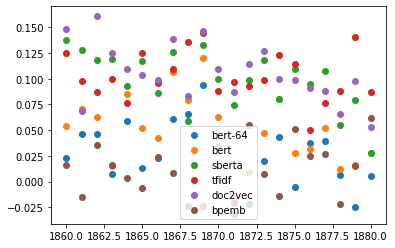

In [6]:
for model_name, res in all_results.items():
    plt.scatter(all_years, res, label=model_name)
plt.legend()
plt.show()

In [8]:
{name: np.mean(data) for name, data in all_results.items()}

{'bert-64': 0.02571815395181821,
 'bert': 0.04946073909798193,
 'sberta': 0.09819125062656418,
 'tfidf': 0.10262037501722461,
 'doc2vec': 0.10550837990504472,
 'bpemb': 0.01063808592849024}